# Summary of data cleaning

The data has been cleaned from the original data provided by the Centers for Disease Control and Prevention (CDC: https://covid.cdc.gov/covid-data-tracker/) following the process below:

|Variable Names|Data Quality Issue|Handling Strategy|Justification
|-|-|-|-
|case_month|No issue|-|-
|case_positive_specimen_interval|47.372% Missing|Drop|Too many data points are missing. Imputing with median/ mode may lead to faulty prediction results.
|case_onset_interval|57.272% Missing|Drop|Too many data points are missing. Imputing with median/ mode may lead to faulty prediction results.
|res_state|0.004% Missing|Imputed as 'Missing'|CDC inputs non-provided data to 'Missing', not that the actual values are missing
|state_fips_code|0.004% Missing|Imputed as 'Missing'|CDC inputs non-provided data to 'Missing', not that the actual values are missing
|res_county	37583|5.758% Missing|Imputed as 'Missing'|CDC inputs non-provided data to 'Missing', not that the actual values are missing
|county_fips_code|5.785% Missing|Imputed as 'Missing'|CDC inputs non-provided data to 'Missing', not that the actual values are missing
|age_group|0.81% Missing|Imputed as 'Missing'|CDC inputs non-provided data to 'Missing', not that the actual values are missing
|sex|2.31% Missing|Imputed as 'Missing'|CDC inputs non-provided data to 'Missing', not that the actual values are missing
|race|12.342% Missing|Imputed as 'Missing'|CDC inputs non-provided data to 'Missing', not that the actual values are missing
|ethnicity|13.57% Missing|Imputed as 'Missing'|CDC inputs non-provided data to 'Missing', not that the actual values are missing
|process|No issue|Leave as it is|CDC inputs non-provided data to 'Missing', not that the actual values are missing
|exposure_yn|No issue|Leave as it is|CDC inputs non-provided data to 'Missing', not that the actual values are missing
|current_status|No issue|Leave as it is|-|
|symptom_status|No issue|Leave as it is|CDC inputs non-provided data to 'Missing', not that the actual values are missing.
|hosp_yn|No issue|Leave as it is|CDC inputs non-provided data to 'Missing', not that the actual values are missing
|icu_yn|No issue|Leave as it is|CDC inputs non-provided data to 'Missing', not that the actual values are missing
|death_yn|No issue|Leave as it is|-|
|underlying_conditions_yn|91.622% Missing|Drop|Too much data is missing


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE

In [31]:
#Loading the cleaned dataset
df = pd.read_csv("covid19-cdc-cleaned-23200757-new.csv", low_memory=False)
df.head()

,case_month,res_state,state_fips_code,res_county,county_fips_code,age_group,sex,race,ethnicity,process,exposure_yn,current_status,symptom_status,hosp_yn,icu_yn,death_yn
0,2022-01-01,AL,1.0,MONTGOMERY,1101.0,65+ years,Male,White,Non-Hispanic/Latino,Missing,Missing,Laboratory-confirmed case,Unknown,Unknown,Missing,Yes
1,2021-08-01,AL,1.0,HOUSTON,1069.0,65+ years,Male,White,Non-Hispanic/Latino,Missing,Missing,Laboratory-confirmed case,Missing,No,Missing,Yes
2,2021-12-01,KY,21.0,Missing,Missing,65+ years,Male,White,Non-Hispanic/Latino,Clinical evaluation,Missing,Probable Case,Symptomatic,Yes,Unknown,Yes
3,2020-07-01,AZ,4.0,PIMA,4019.0,65+ years,Male,White,Hispanic/Latino,Missing,Missing,Laboratory-confirmed case,Symptomatic,Yes,Missing,Yes
4,2020-04-01,NY,36.0,BRONX,36005.0,65+ years,Female,White,Non-Hispanic/Latino,Missing,Missing,Laboratory-confirmed case,Unknown,Yes,Unknown,Yes


In [32]:
# Review the datatypes
df.dtypes

case_month          object
res_state           object
state_fips_code     object
res_county          object
county_fips_code    object
age_group           object
sex                 object
race                object
ethnicity           object
process             object
exposure_yn         object
current_status      object
symptom_status      object
hosp_yn             object
icu_yn              object
death_yn            object
dtype: object

In [33]:
# Selecting the columns with object type
categories = df.select_dtypes(['object']).columns

# Converting data type of the above columns to category
for column in categories:
    df[column] = df[column].astype('category')

df.dtypes

case_month          category
res_state           category
state_fips_code     category
res_county          category
county_fips_code    category
age_group           category
sex                 category
race                category
ethnicity           category
process             category
exposure_yn         category
current_status      category
symptom_status      category
hosp_yn             category
icu_yn              category
death_yn            category
dtype: object

# 1. [25] **Data Understanding and Preparation:**

Exploring relationships between feature pairs and selecting/transforming promising features based on a given training set.

#### As visible above, the data has no continuous features.
## 1.1 Splitting the dataset: 70% training and 30% testing. The dataset has no continuous features.

In [34]:
target_feature = 'death_yn'
training_dataframe, testing_dataframe = train_test_split(df, test_size=0.3, random_state=30)
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != target_feature],
                                                    df[target_feature], test_size=0.3, random_state=30)
print(df.shape,X_train.shape,y_train.shape,y_test.shape)

(50000, 16) (35000, 15) (35000,) (15000,)


## 1.2 Plots for pairwise interaction of categorical features with the target feature

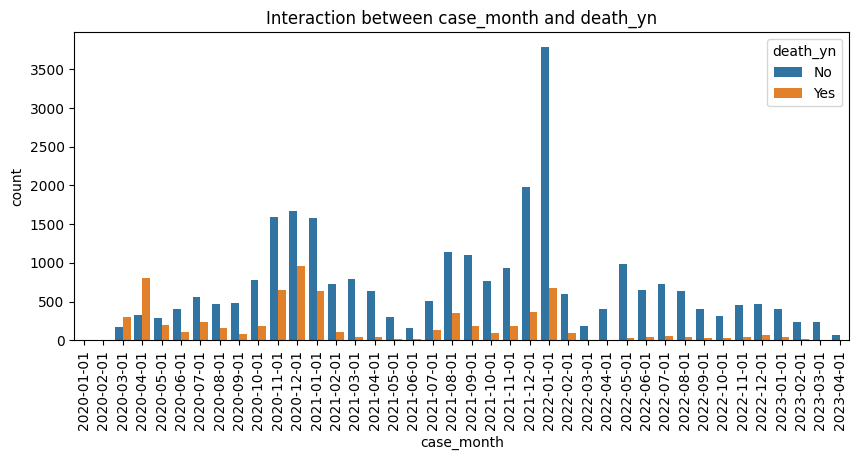

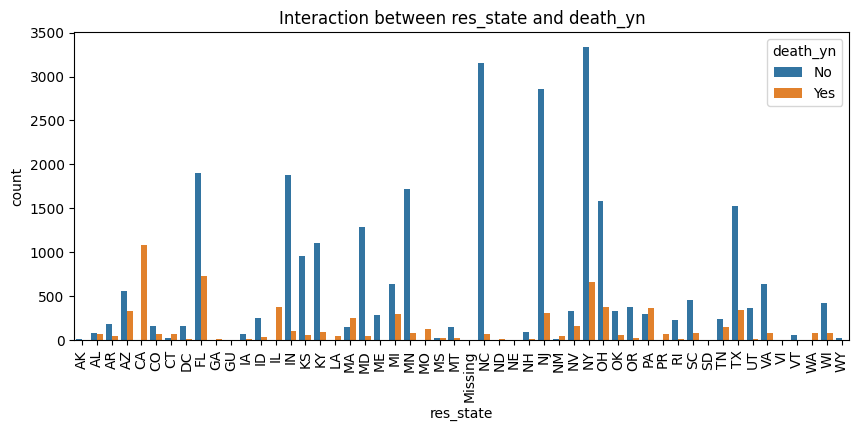

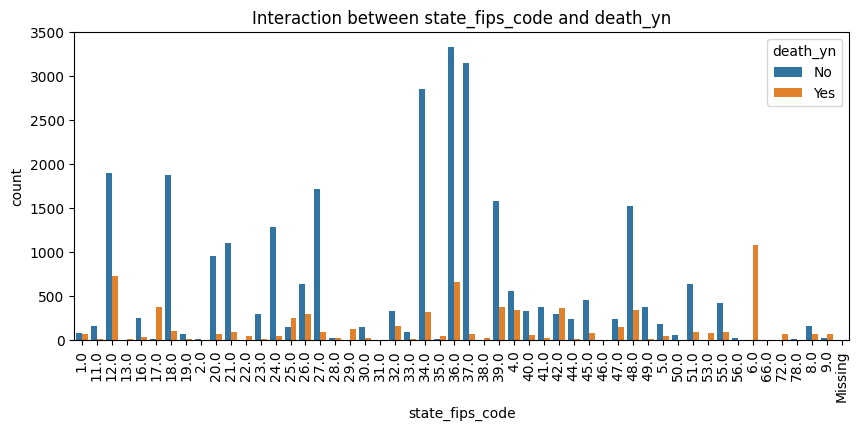

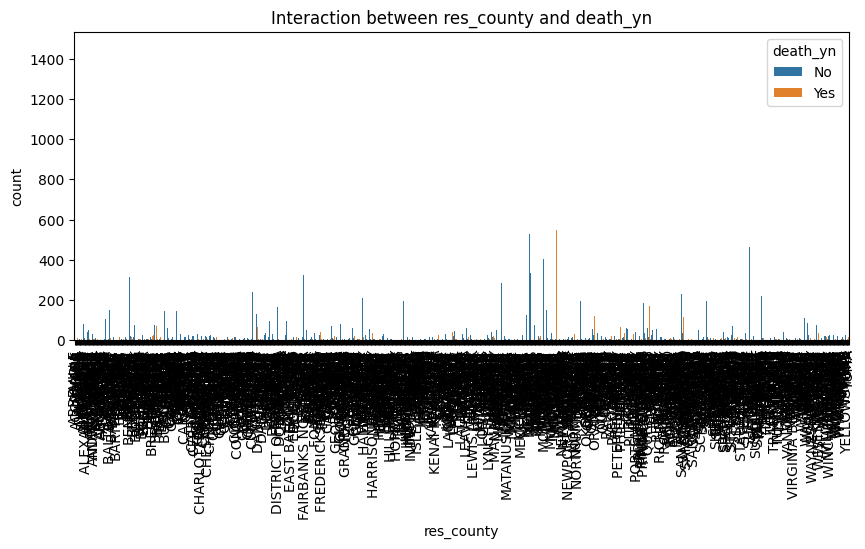

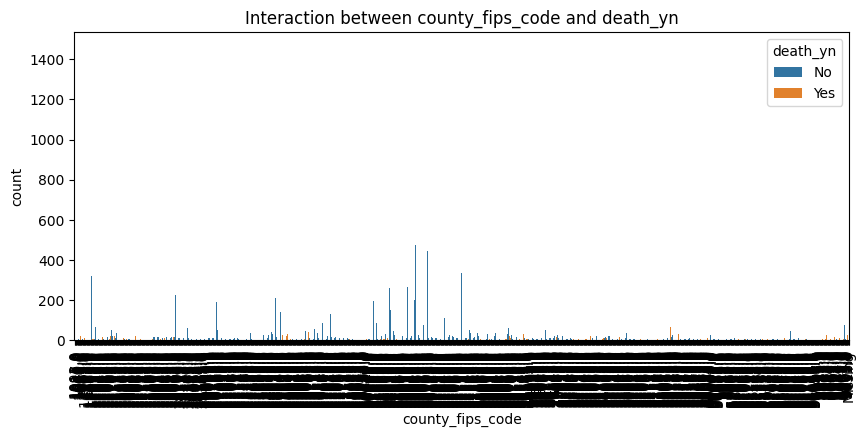

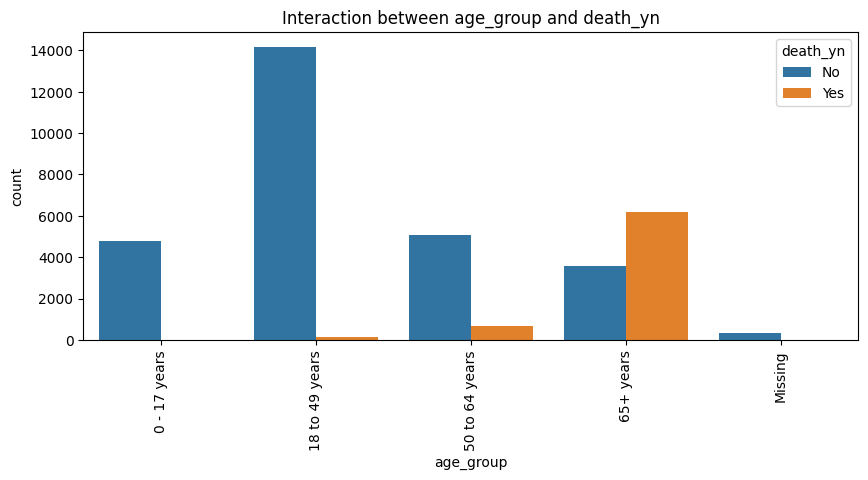

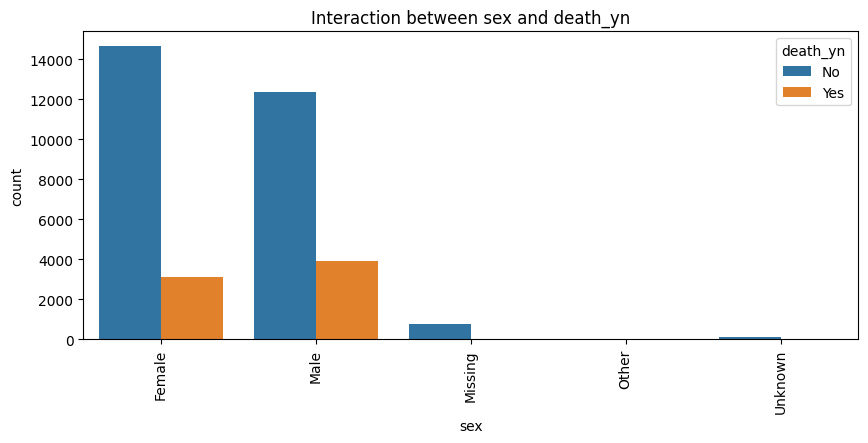

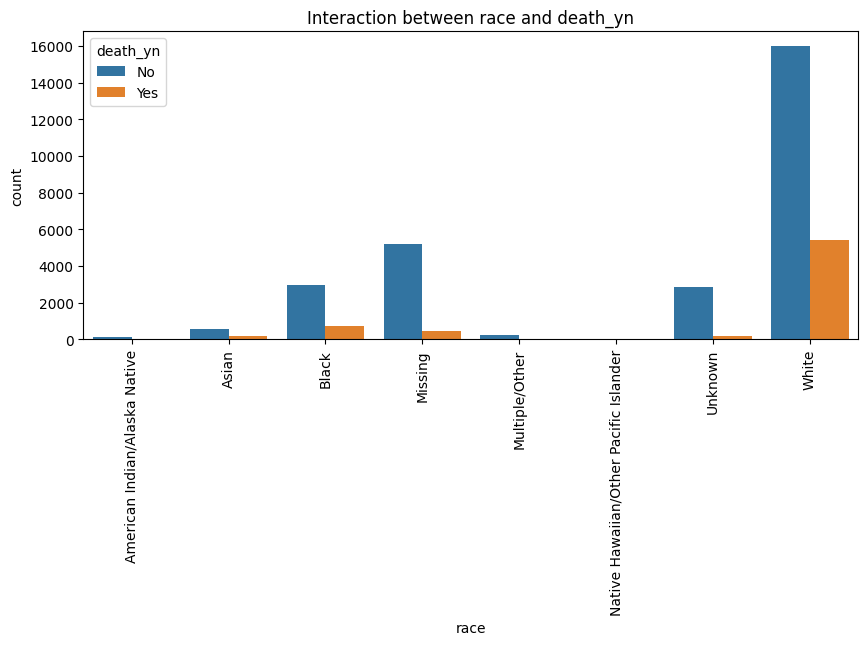

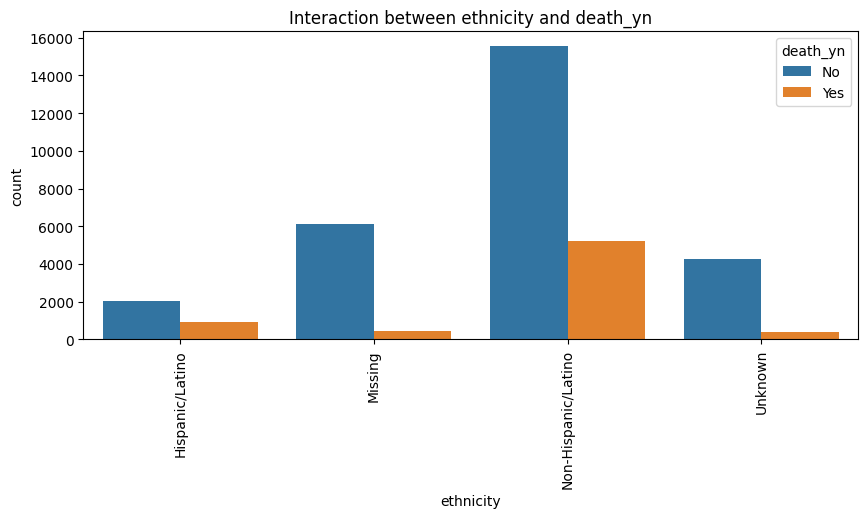

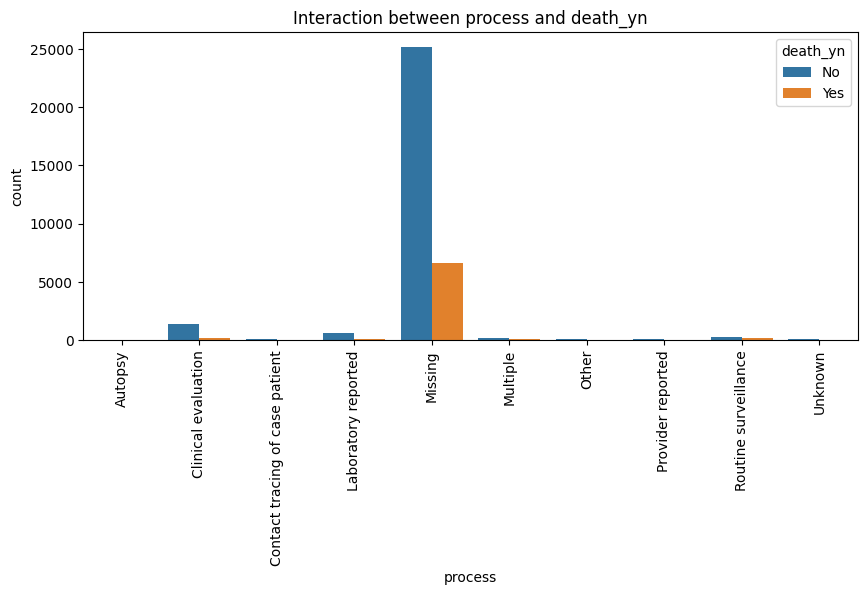

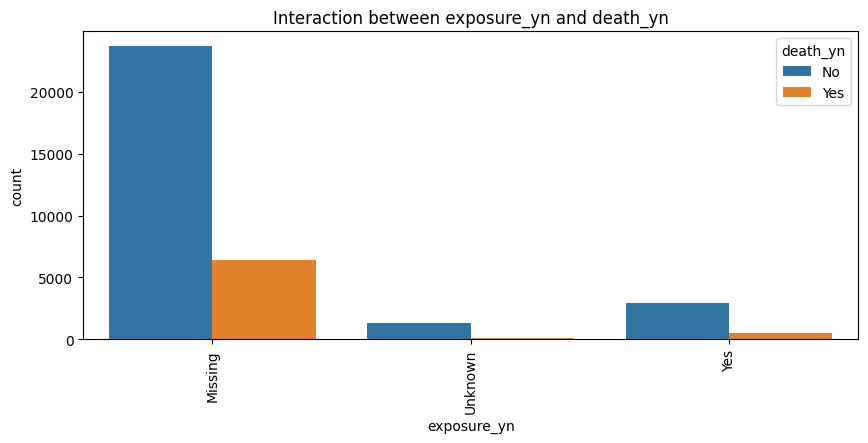

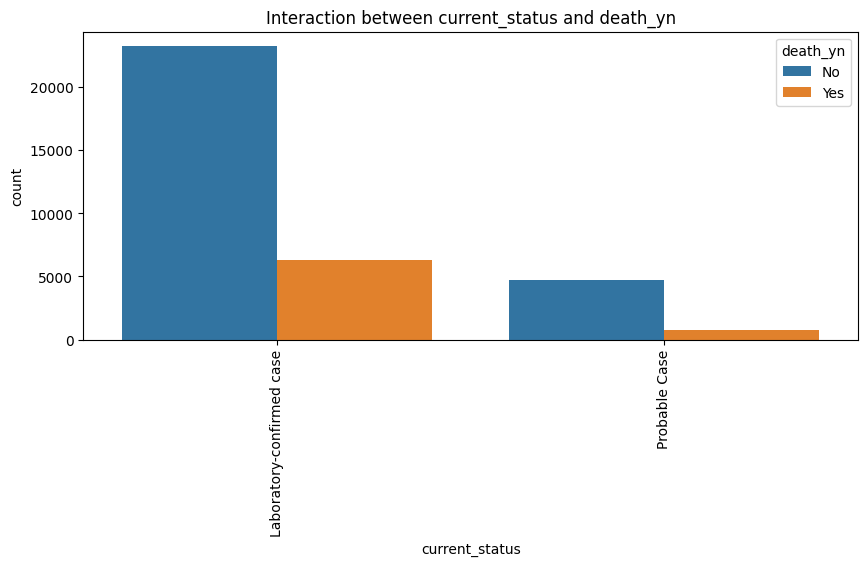

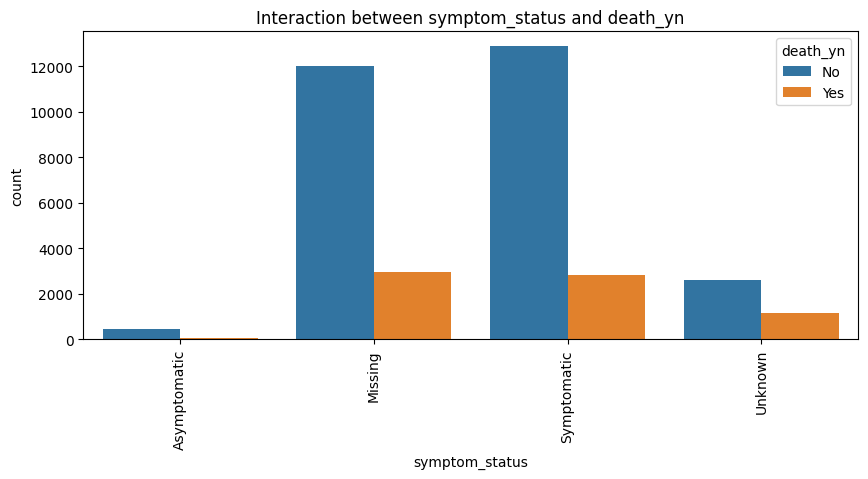

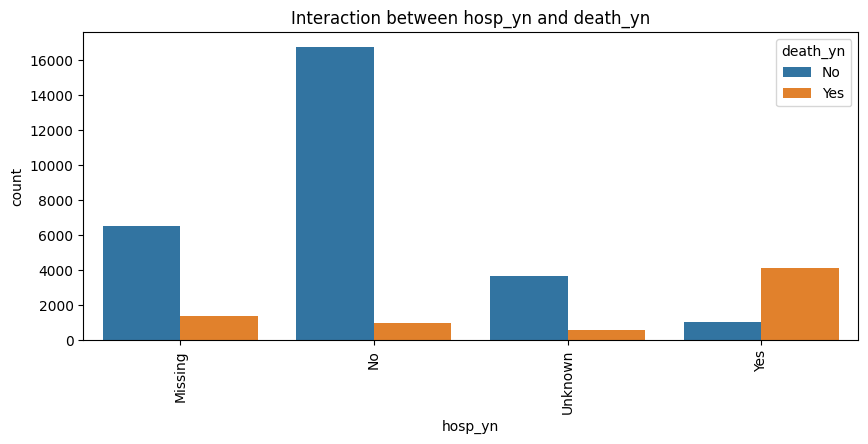

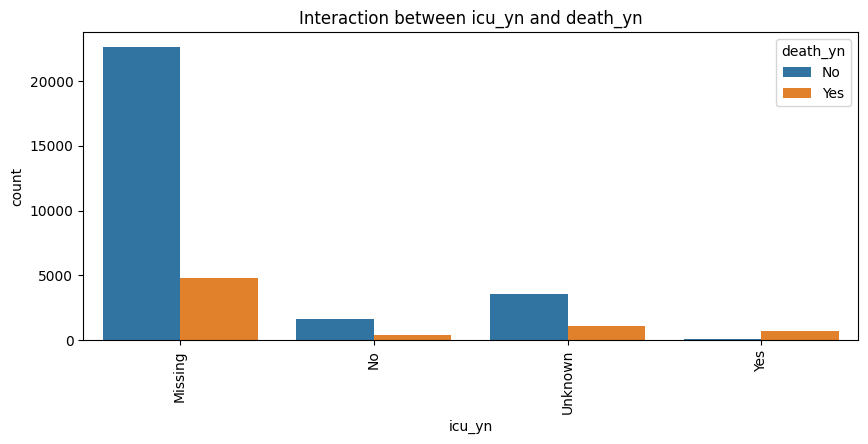

In [36]:
for feature in categories:
    if feature != target_feature:
        plt.figure(figsize=(10,4))
        sns.countplot(x=feature, hue=target_feature, data=pd.concat([X_train, y_train.to_frame()], axis=1))
        plt.title(f"Interaction between {feature} and {target_feature}")
        plt.xticks(rotation=90)
        plt.show()

## Promising features:

- case_month: The month of the case can play a role in death outcome prediction:
    - The number of deaths seem to be on a decreasing trend over every passing month, especially after January 2022.
    - Another trend which seems to be visible is that cold weather( months of november, december, january) leads to more deaths due to COVID-19 compared to rest of the months.  

- res_state: state of residence has an effect on the death probability:
    - The plot shows that some states have a very low death rate (such as GA, ND, NE), while others like CA, NY have a very high death rate.

- age_group: Age group appears to have a significant impact on death outcome:
    - People having ages of 65 and above have higher tendency of succumbing to death, while the risk for lower age groups of "0-17 years" is lowest.

- sex: sex can affect death outcomes:
    - Males tend to have higher death rate than Females.
    
- race: race can affect death outcomes:
    - "Asian", "Unknown" and "Alaska Native" races have far lower death rate,
    - 'White' has highest death rate.
    
- ethnicity: ethnicity can affect death outcomes:
    - 'Missing' and 'Unknown' races have far lower death rate.
    - "Non-Hispanic/ Latino" race has highest death count but "Hispanic/Latino" have highest ratio of death.
    
- current_status: Whether the case is lab-confirmed or not can affect death outcomes:
    - Lab-confirmed cases have higher death count.
    
- symptom_status: Whether cases have or does not have symptoms can affect death outcomes:
    - Patients with "Unknown" symptom_status have the highest proportion of death.
    - Patients with "Missing" symptom status have slightly higher death risk than symptomatic.
    
- hosp_yn: The treatment method can indicate death outcomes:
    - Cases which required hospital treatment had higher death outcome.
    
- icu_yn: The treatment method can also provide insight into death outcomes:
    - Most cases which reuired ICU treatments lead to death.

### Not really promissing features:
- state_fips_code:
    - We already have res_state which shows the same information. Using acronyms for states makes it easier to interpret results.
- res_county and county_fips_code represent the county of residence:
    - These features have high cardinality.The training subsets are far too small for such high cardinality. Also, for predictions based on geography we have res_state which is a promising feature.
- process:
    - Majority of data is stated as "missing". Might lead to bias in prediction.
- exposure_yn:
    - Majority of data is stated as "missing". Might lead to bias in prediction.
    - This feature tells us whether a patient is in contact with others who got infected, which tells more about the source of the virus and/or the risk of spreading the virus to others, but doesn't give certain information about how it affects the death outcome of a COVID-19 case.

## 1.3 Prepare data & evaluation function for predictive modeling

In [37]:
# Selecting the promising features based on the discussion above:
predictive_feature = ["case_month", "res_state", "age_group", "sex", "race", "ethnicity", "current_status",
                      "symptom_status","hosp_yn","icu_yn"]

target_feature = "death_yn"

### Full dataset

In [38]:
# Creating dummy variables to represent categorical data
X = df[predictive_feature]
X = pd.get_dummies(X)
X.shape

(50000, 128)

In [39]:
# Assign target feature to Y
y = df[target_feature]
y.shape

(50000,)

In [40]:
# representing the target feature in form of 1 and 0, for yes and no respectively
y_lnr = y.map({'Yes':1, 'No':0})
y_lnr.shape

(50000,)

### Training dataset

In [41]:
# Creating dummy variables to represent categorical data
X_train = X_train[predictive_feature]
X_train = pd.get_dummies(X_train)
X_train.shape

(35000, 128)

In [42]:
# Target feature in training dataset
y_train.shape

(35000,)

In [43]:
# representing the target feature in form of 1 and 0, for yes and no respectively
y_train_nmr = y_train.map({'Yes':1, 'No':0})
y_train_nmr.shape

(35000,)

### Testing dataset

In [45]:
# Creating dummy variables to represent categorical data
X_test = X_test[predictive_feature]
X_test = pd.get_dummies(X_test)
X_test.shape

(15000, 128)

In [46]:
# Target feature in testing dataset
y_test.shape

(15000,)

In [47]:
# representing the target feature in form of 1 and 0, for yes and no respectively
y_test_nmr = y_test.map({'Yes':1, 'No':0})
y_test_nmr.shape

(15000,)

In [48]:
def evaluate(y_true,y_predict,pos_label="Yes"):

    #Calculating and printing the accuracy
    accuracy = accuracy_score(y_true, y_predict)
    print("Accuracy:", accuracy)

    #Calculating and printing the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_predict)
    print("Confusion Matrix:\n", conf_matrix)

    #Calculating and printing the precision
    precision = precision_score(y_true, y_predict, pos_label=pos_label, zero_division=1)
    print("Precision:", precision)

    #Calculating and printing recall
    recall = recall_score(y_true, y_predict, pos_label=pos_label)
    print("Recall:", recall)

    #Calculating and printing F1
    f1 = f1_score(y_true, y_predict, pos_label=pos_label)
    print("F1 Score:", f1)

    return accuracy,conf_matrix,precision,recall,f1

In [49]:
def cross_validate(model, X, y, cv=5):
    #printing and returning all parameters for cross validation of prediction
    accuracy_scores_rf = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print("Cross-validated Accuracy:", np.mean(accuracy_scores_rf))

    precision_scores_rf = cross_val_score(model, X, y, cv=5, scoring='precision_macro')
    print("Cross-validated Precision:", np.mean(precision_scores_rf))

    recall_scores_rf = cross_val_score(model, X, y, cv=5, scoring='recall_macro')
    print("Cross-validated Recall:", np.mean(recall_scores_rf))

    f1_scores_rf = cross_val_score(model, X, y, cv=5, scoring='f1_macro')
    print("Cross-validated F1 Score:", np.mean(f1_scores_rf))

    return np.mean(accuracy_scores_rf), np.mean(precision_scores_rf), np.mean(recall_scores_rf), np.mean(f1_scores_rf)

# 2. [15] Predictive Modeling: Linear Regression.  

## 2.1 On the training set, train a linear regression model to predict the target feature

In [50]:
# Train the linear regression model using train dataset
lnr = LinearRegression()
lnr.fit(X_train, y_train_nmr)

LinearRegression()

## 2.2 Print the coefficients learned by the model and discuss their role in the model

(e.g., interpret the model by analysing each coefficient and how it relates each input feature to the target feature)

In [51]:
# display options for coefficients
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# Print the intercept and weights learned for each feature.
print("\nIntercept: \n", lnr.intercept_)

lnr_coefficients = pd.DataFrame(lnr.coef_, X_train.columns, columns=["Coefficient"])
lnr_coefficients = lnr_coefficients.sort_values(by=["Coefficient"],ascending=False)
print(lnr_coefficients)


Intercept: 
 686361344353.4844
                                              Coefficient
sex_Male                                     5.934406e+12
sex_Unknown                                  5.934406e+12
sex_Missing                                  5.934406e+12
sex_Female                                   5.934406e+12
race_White                                   3.483544e+12
race_Black                                   3.483544e+12
race_Asian                                   3.483544e+12
race_American Indian/Alaska Native           3.483544e+12
race_Unknown                                 3.483544e+12
race_Missing                                 3.483544e+12
race_Multiple/Other                          3.483544e+12
race_Native Hawaiian/Other Pacific Islander  3.483544e+12
sex_Other                                    1.644753e+12
res_state_NE                                 3.722392e+11
res_state_MO                                 3.722392e+11
res_state_ND                            

###Summary of the coefficients

|Feature|Coefficients
|--|--
|race|  3.483544e+12
|res_state   |  3.722392e+11
|case_month  |  8.015462e+07
|ethnicity              |  -8.190721e+11
|symptom_status                     | -2.575318e+12
|icu_yn                             | -6.985970e+11
|age_group                        | -1.829339e+11
|sex                                | 5.934406e+12
|hosp_yn                                | -1.942508e+12
|current_status               | -4.550596e+12

###The roles of the coefficients:

Linear regression model makes use of linear equation to predict the death outcome of a COVID-19 case, based on the independent variables. Each feature/ variable has its own coeffecients indicating the relationship between the predictive features and death outcome.

The following conclusions can be drawn upon observing the coefficients above:-

    The coefficients for race, sex and current status have the highest magnitude among all features, which imply that they have the most influence on the death outcome.
    
    The coefficients for symptom status, icu_yn and ethnicity have the lowest magnitude among all features, which imply that they have the least influence on the death outcome.

Since, both dependent and independent variables are categorical in nature rather than being in numbers, so none of the pairwise interaction of features with the target feature can be analysed using magnitude and sign of the coefficients as normal continuous set of problems.hence, it makes more sense to use logistic regression rather than linear regression for categorical features.

## 2.3 Print the predicted target feature value for the first 10 training examples.

Threshold the predicted target feature value given by the linear regression model at 0.5, to get the predicted class for each example.

In [54]:
#Predict the target feature value for the first 10 training examples:
y_pred_lnr_train = lnr.predict(X_train)
print("Predicted target feature values for the first 10 training examples:", y_pred_lnr_train[:10])

#Threshold the predicted target feature value and print the predicted class for the first 10 examples:
y_pred_lnr_train_class = (y_pred_lnr_train >= 0.5).astype(int)
print("Predicted class for the first 10 training examples:", y_pred_lnr_train_class[:10])

Predicted target feature values for the first 10 training examples: [ 0.60644531  0.44970703  0.12158203  0.12695312  0.3503418   0.08081055
 -0.0078125  -0.10083008  0.97949219  0.96484375]
Predicted class for the first 10 training examples: [1 0 0 0 0 0 0 0 1 1]


In [55]:
#Classification evaluation measures for training set
print("LINEAR REGRESSION(TRAINING SET)")
evaluate_lnr_train = evaluate(y_train_nmr,y_pred_lnr_train_class,1)

LINEAR REGRESSION(TRAINING SET)
Accuracy: 0.9480285714285714
Confusion Matrix:
 [[27352   605]
 [ 1214  5829]]
Precision: 0.9059682934410942
Recall: 0.8276302711912538
F1 Score: 0.8650293091934408


##Findings:

Accuracy  of 0.948 means that the model successfully predicted the class for roughly 94.8% of the test data. This suggests that the classification model has an overall great accuracy.

The confusion matrix showed that the model correctly identifies 27352 instances as true negatives and 5829 instances as true positives, but incorrectly classified  605 instances as false positives and 1214 instances as false negatives indicating towards the model having a higher rate of correctly identifying negative instances than positive instances.

The precision of the model is 0.9059, which means that out of all the instances that the model predicted as positive, 90.59% were actually positive.

The model has recall of 0.8276, implying that out of all the positive instances in the test set, the model correctly identified 82.76%. In this specific problem of predicting death outcome of a COVID-19 patient, mispredicting "Yes" death outcome as "No" can lead to negative consequences such as less allocation of medical resources towards treatment of patient.

The F1 score, which is a weighted average of precision and recall is 0.865. This indicates that the model has struck a good balance between correctly identifying positive instances (recall) and correctly predicting the class of positive instances (precision).

## 2.4 Evaluate the model using classification evaluation measures on the hold-out (30% examples) test set


In [56]:
#Evaluate the model on the hold-out test set:
y_pred_lnr_test = lnr.predict(X_test)
y_pred_lnr_test_class = (y_pred_lnr_test >= 0.5).astype(int)

print("LINEAR REGRESSION(TEST SET)")
evaluate_lnr_test = evaluate(y_test_nmr,y_pred_lnr_test_class,1)

LINEAR REGRESSION(TEST SET)
Accuracy: 0.9484666666666667
Confusion Matrix:
 [[11753   290]
 [  483  2474]]
Precision: 0.8950795947901592
Recall: 0.8366587757862699
F1 Score: 0.8648837615801434


### Evaluating the model on the hold-out test set:

All metrics are more or less the same when running on the training set (within the +- 0.1), and points towards same conclusion: the model has great accuracy and precision, but have lower recall and incorrectly classifies quite a number of positive instances as negative, which means that it could give wroing prediction for "Yes" death outcome as "No".

In [57]:
# Cross validating using classic k-fold
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True)
kf.get_n_splits(X)

5

In [63]:
#Empty lists to store the scores for all folds
accuracy = []
precision = []
recall = []
f1 = []

linear_cv=LinearRegression()

for i, (train_index, val_index) in enumerate(kf.split(X)):
    print("Fold number",i)

    X_train_val, y_train_val = X.iloc[train_index], y_lnr.iloc[train_index]
    X_test_val, y_test_val = X.iloc[val_index], y_lnr.iloc[val_index]

    linear_cv.fit(X_train_val, y_train_val)

    y_pred = linear_cv.predict(X_test_val)
    y_pred_class = (y_pred >= 0.5).astype(int)

    accuracy_val = accuracy_score(y_test_val, y_pred_class)
    accuracy.append(accuracy_val)

    precision_val = precision_score(y_test_val, y_pred_class)
    precision.append(precision_val)

    recall_val = recall_score(y_test_val, y_pred_class)
    recall.append(recall_val)

    f1_val = f1_score(y_test_val, y_pred_class)
    f1.append(f1_val)


    print("Accuracy:", accuracy_val, "\n", "Precision:", precision_val,"\n", "Recall:", recall_val,"\n","F1:", f1_val, )

Fold number 0
Accuracy: 0.9494 
 Precision: 0.9158337716991057 
 Recall: 0.8342117872544322 
 F1: 0.8731193580742227
Fold number 1
Accuracy: 0.9478 
 Precision: 0.9059734513274337 
 Recall: 0.8231155778894472 
 F1: 0.862559241706161
Fold number 2
Accuracy: 0.9495 
 Precision: 0.8991179713340683 
 Recall: 0.8351254480286738 
 F1: 0.8659410671621981
Fold number 3
Accuracy: 0.9445 
 Precision: 0.8941429339065019 
 Recall: 0.8229475766567754 
 F1: 0.8570692763327324
Fold number 4
Accuracy: 0.9477 
 Precision: 0.8921298844248762 
 Recall: 0.832135523613963 
 F1: 0.8610889774236388


In [64]:
#printing averages for evaluation parameters aling with standard deviation for all the folds
accuracy_linear_cv_mean, accuracy_linear_cv_std = np.mean(accuracy), np.std(accuracy)
precision_linear_cv_mean, precision_linear_cv_std = np.mean(precision), np.std(precision)
recall_linear_cv_mean, recall_linear_cv_std = np.mean(recall), np.std(recall)
f1_linear_cv_mean, f1_linear_cv_std = np.mean(f1), np.std(f1)

cross_validate_lnr = [accuracy_linear_cv_mean, precision_linear_cv_mean, recall_linear_cv_mean, f1_linear_cv_mean]

print("Average Accuracy score: {} +/- {:.2f}".format(accuracy_linear_cv_mean, accuracy_linear_cv_std))
print("Average Precision score: {} +/- {:.2f}".format(precision_linear_cv_mean, precision_linear_cv_std))
print("Average Recall score: {} +/- {:.2f}".format(recall_linear_cv_mean, recall_linear_cv_std))
print("Average F1 score: {} +/- {:.2f}".format(f1_linear_cv_mean, f1_linear_cv_std))

Average Accuracy score: 0.9477800000000001 +/- 0.00
Average Precision score: 0.9014396025383972 +/- 0.01
Average Recall score: 0.8295071826886584 +/- 0.01
Average F1 score: 0.8639555841397906 +/- 0.01


### Findings from the comparison between the test set result and cross-validated model's results:

The evaluation metrics calculated on the hold-out (30% examples) test set:

    Test Accuracy: 94.84% of the predictions are correct
    Test Precision: 89.51% of the 'Yes' predictions are correct
    Test Recall: 83.66% of the actual 'Yes' cases are predicted correctly
    Test F1 Score: 86.48% shows harmonic mean of precision and recall

The cross-validated model evaluation metrics averaged across 5 folds:

    Cross-validated Accuracy: 94.77% of the predictions are correct
    Cross-validated Precision: 90.14% of the 'Yes' predictions are correct
    Cross-validated Recall: 82.95% of the actual 'Yes' cases are predicted correctly
    Cross-validated F1 Score: 86.39% shows harmonic mean of precision and recall

###Summary of linear regression:

Given that all the data is categorical in nature, it is difficult to determine which feature has stronger relation to death_yn just based on coefficients and magnitude.
The poor recall rate and high precision of the model indicate there could be negative consequences due to incorrect prediction from the model which could lead to death of patient. Therefore, there is need for a better model to reduce the occurence of false-negative errors.

# 3 Logistic Regression model

## 3.1 Train a Logistic Regression model

In [65]:
logr = LogisticRegression(max_iter=1000)
logr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

## 3.2 Print the coefficients learned by the model and discuss their role in the model

In [66]:
# display options for coefficients
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

logr_coefficients = pd.DataFrame(logr.coef_[0], X_train.columns, columns=["Coefficient"])
logr_coefficients = logr_coefficients.sort_values(by=["Coefficient"],ascending=False)
print(logr_coefficients)

                                             Coefficient
res_state_CA                                    5.862997
res_state_PR                                    4.385757
res_state_WA                                    3.382119
age_group_65+ years                             3.322215
res_state_MO                                    3.133071
res_state_IL                                    2.985682
case_month_2020-04-01                           2.813842
case_month_2020-03-01                           2.737460
case_month_2020-05-01                           1.674278
hosp_yn_Yes                                     1.625260
res_state_GA                                    1.529671
res_state_ND                                    1.526191
case_month_2020-01-01                           1.517972
case_month_2021-08-01                           1.406505
res_state_NM                                    1.344260
case_month_2020-12-01                           1.311033
case_month_2020-11-01          

### Roles of the coefficients:
In logistic regression, coefficients represent how each feature increases the probability of a certain outcome which in our case would be "Yes" or "No". A positive coefficient means that the feature increases the odds of a "Yes" outcome, while a negative coefficient decreases those odds, on the other hand, the magnitude of each coefficient indicates the strength of its impact.

When we run a logistic regression model, we receive a set of coefficients for each feature, including case_month, res_state, race, sex etc. For instance, the coefficient for "case_month_2020-03-01" is 2.737460, indicating that cases from March 2021 have higher odds of a "Yes" outcome than the reference category. On the other hand, a negative coefficient, like -1.149765 for "case_month_2023-04-01"(-1.444936), implies that cases from April 2023 have lower odds of a "Yes" outcome compared to the reference category.

Reference categories are the baseline levels of categorical features in order to evaluate the effects which other levels have on the odds of the outcome. When defining dummy variables for each category(feature),these reference categories are excluded and serve as a benchmark when interpreting the coefficients of the other levels.


## 3.3 Print the predicted target feature value for the first 10 training examples. Print the predicted class for the first 10 examples.

In [67]:
# Predict target feature values and class for the first 10 training examples
y_train_logr_pred = logr.predict(X_train)
y_train_logr_pred_prob = logr.predict_proba(X_train)[:, 1]

print("Predicted target feature values for the first 10 training examples:")
print(y_train_logr_pred_prob[:10])
print("Predicted class for the first 10 training examples:")
print(y_train_logr_pred[:10])

Predicted target feature values for the first 10 training examples:
[7.32003424e-01 6.04851587e-01 1.89557444e-02 2.71933260e-03
 1.77241181e-01 2.49405456e-03 1.27466848e-03 3.00548149e-04
 9.92555110e-01 9.83325610e-01]
Predicted class for the first 10 training examples:
['Yes' 'Yes' 'No' 'No' 'No' 'No' 'No' 'No' 'Yes' 'Yes']


In [71]:
# Compute evaluation metrics on the full training set
print("LOGISTIC REGRESSION(TRAINING SET)")
evaluate_logr_train = evaluate(y_train, y_train_logr_pred)

y_test_logr_pred = logr.predict(X_test)

LOGISTIC REGRESSION(TRAINING SET)
Accuracy: 0.9555714285714285
Confusion Matrix:
 [[27256   701]
 [  854  6189]]
Precision: 0.8982583454281567
Recall: 0.8787448530455771
F1 Score: 0.8883944591975883


### Findings:

The accuracy has a score of 0.955, indicating that 95.5% instances of the training set were predicted correclty and the logistic regression model performed well on training data.

The confusion matrix shows 6189 true positives (correct predition of Yes class), 27256 true negatives (correct predictions of No class), 701 false positives (incorrect prediction for Yes class), and 854 false negatives (incorrect prediction of No class).

The precision of 89.82% shows the percentage of truely "Yes" predictions, showing good performance of the model to avoid false positives.The recall shows that the model was able to identify 87.87% of the Yes examples.

Lastly, the F1 score shows the harmonic mean of precision and recall, with a score of 0.8883, indicating a reasonable balance between precision and recall.

Overall, the logistic regression model did quite well on the training data, nevertheless we need to evaluate it on the test data to avoid overfitting and gain insight into its capability to work with unseen data.

## 3.4 Evaluate the model using classification evaluation measures on the hold-out (30% examples) test set. Compare these results with the evaluation results obtained when using the training (70%) dataset for evaluation. Also compare these results with a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset).

In [72]:
# Evaluate the model on the hold-out test set
print("LOGISTIC REGRESSION(TEST SET)")
evaluate_logr_test = evaluate(y_test, y_test_logr_pred)

# Cross-validated model
logr_cv = LogisticRegression(max_iter=1000)
cross_validate_logr = cross_validate(logr_cv, X, y, cv=5)

LOGISTIC REGRESSION(TEST SET)
Accuracy: 0.9554
Confusion Matrix:
 [[11716   327]
 [  342  2615]]
Precision: 0.888851121685928
Recall: 0.8843422387554954
F1 Score: 0.8865909476182403
Cross-validated Accuracy: 0.95458
Cross-validated Precision: 0.9323411301237681
Cross-validated Recall: 0.9245875
Cross-validated F1 Score: 0.9283899526070328


### Findings from the comparison:

The evaluation metrics calculated on the hold-out (30% examples) test set:

    Test Accuracy: 95.54% of the predictions are correct
    Test Precision: 88.88% of the 'Yes' predictions are correct
    Test Recall: 88.43% of the actual 'Yes' cases are predicted correctly
    Test F1 Score: 88.65% shows harmonic mean of precision and recall

The cross-validated model evaluation metrics averaged across 5 folds:

    Cross-validated Accuracy: 95.45% of the predictions are correct
    Cross-validated Precision: 93.23% of the 'Yes' predictions are correct
    Cross-validated Recall: 92.45% of the actual 'Yes' cases are predicted correctly
    Cross-validated F1 Score: 92.83% shows harmonic mean of precision and recall

###Summary of logistic regression:
Compared to linear regression, we can see higher recall, higher precision, accuracy and subsequently higher F1 as well, hence making it a more reliable model for predicting whether a patient will die due to COVID-19, leading to better medical attention being given to the patient.

# 4 Random forest model

## 4.1 On the training set, train a random forest model to predict the target feature, using the descriptive features selected in exercise (1) above.

In [91]:
# train the random forest model on the training set
rndmf = RandomForestClassifier(random_state=30)
rndmf.fit(X_train, y_train)

RandomForestClassifier(random_state=30)

## 4.2 Can you interpret the random forest model? Discuss any knowledge you can gain in regard of the working of this model.   

A Random Forest model is an ensemble of Decision Tree models. Random Forest can be used for either classification or regression. It combines multiple decision trees created by combining the training data and features set, and then combines their results to obtain the final output. This model is known for its capability to handle multi class problems and provides pretty accurate results by average multiple trees' predictions. By analysing the trees in the ensemble of trees and their respective feature importance scores, we can understand the relationship between features and the target feature(death_yn).

## 4.3 Print the predicted target feature value for the first 10 training examples.

In [92]:
# Predict the target feature values and classes for the first 10 training examples
y_train_rndmf_pred = rndmf.predict(X_train)
y_train_rndmf_pred_prob = rndmf.predict_proba(X_train)[:, 1]

print("Predicted target feature values for the first 10 training examples:")
print(y_train_rndmf_pred_prob[:10])
print("Predicted class for the first 10 training examples:")
print(y_train_rndmf_pred[:10])

print("RANDOM FOREST(TRAINING SET)")
evaluate_rndmf_train = evaluate(y_train, y_train_rndmf_pred)

Predicted target feature values for the first 10 training examples:
[0.69395707 0.39205403 0.         0.         0.04       0.
 0.         0.         1.         0.99571429]
Predicted class for the first 10 training examples:
['Yes' 'No' 'No' 'No' 'No' 'No' 'No' 'No' 'Yes' 'Yes']
RANDOM FOREST(TRAINING SET)
Accuracy: 0.9883714285714286
Confusion Matrix:
 [[27743   214]
 [  193  6850]]
Precision: 0.9697055492638732
Recall: 0.9725969047280988
F1 Score: 0.971149074927341


### Findings so far:

With the accuracy of 98.83%, random forest model seems to be preforming outstandingly well on the training set. Also, there are less false positives and negatives in the confusion matrix, suggesting this model is better than the previous two(linear and logistic). The precision (96.97%) indicates that, among all predicted positive cases, a high proportion of them are true positives. The recall of 97.25% is indicative of the fact that the model is highly capable of identifying actual positive cases.Random Forest seems to perform quite well, exhibiting excellent recall and precision values.This suggests that this model has low rate of false-negative errors. However, to determine whether the model works well on unseen data, it is important to evaluate the model on a test set and use cross validation.

## 4.4 Evaluate the model using classification evaluation measures on the hold-out (30% examples) test set. Compare these results with the evaluation results obtained when using the training (70%) dataset for evaluation. Also compare these results with a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset).

In [95]:
# Evaluate the model on the hold-out test set, compare results with the training dataset
y_test_rndmf_pred = rndmf.predict(X_test)
print("RANDOM FOREST(TEST SET)")
evaluate_rndmf_test = evaluate(y_test, y_test_rndmf_pred)

RANDOM FOREST(TEST SET)
Accuracy: 0.9548666666666666
Confusion Matrix:
 [[11681   362]
 [  315  2642]]
Precision: 0.8794940079893475
Recall: 0.8934731146432194
F1 Score: 0.8864284516020802


In [94]:
# Cross validate
rndmf_cv = RandomForestClassifier(random_state=30)
cross_validate_rndmf = cross_validate(rndmf_cv, X, y, cv=5)

Cross-validated Accuracy: 0.95464
Cross-validated Precision: 0.928414955751164
Cross-validated Recall: 0.930175
Cross-validated F1 Score: 0.9292754461560492


### Findings:

Random Forest model has an accuracy of 95.48% on the test set, indicating that it can accurately predict the outcomes in a majority of cases. The precision of 87.94%, recall of 89.34%, and F1 score of 88.64% are quite high thereby demonstrating the model's capability to effectively identify positive and negative cases on unseen data.

When comparing the test set results with the cross-validated model, the metrics show some differences. The cross-validated accuracy (95.46%), precision (92.84%), recall (93.01%), and F1 score (92.92%) are actually higher than the test set results, suggesting that the model performs better on average across different data splits.

To sum it all up, random forest model performs well on training, test and validation sets. The model's consistent performance suggests it is resilient and capable of handling different dataset.

# 5 Improving Predictive Models

## 5.1 Which model of the ones trained above performs better at predicting the target feature? Is it more   accurate than a simple model that always predicts the majority class (i.e., if 'no' is the majority class in your dataset, the simple model always predicts 'no' for the target feature)? Justify your answers.

In [98]:
summary_data = [("Linear Regression","Train",
         evaluate_lnr_train[0],evaluate_lnr_train[2],evaluate_lnr_train[3],evaluate_lnr_train[4]),
        ("Linear Regression","Test",
         evaluate_lnr_test[0],evaluate_lnr_test[2],evaluate_lnr_test[3],evaluate_lnr_test[4]),
        ("Linear Regression","Cross Validate",
        cross_validate_lnr[0],cross_validate_lnr[1],cross_validate_lnr[2],cross_validate_lnr[3]),
        ("Logistic Regression","Train",
        evaluate_logr_train[0],evaluate_logr_train[2],evaluate_logr_train[3],evaluate_logr_train[4]),
        ("Logistic Regression","Test",
         evaluate_logr_test[0],evaluate_logr_test[2],evaluate_logr_test[3],evaluate_logr_test[4]),
        ("Logistic Regression","Cross Validate",
        cross_validate_logr[0],cross_validate_logr[1],cross_validate_logr[2],cross_validate_logr[3]),
        ("Random Forest","Train",
        evaluate_rndmf_train[0],evaluate_rndmf_train[2],evaluate_rndmf_train[3],evaluate_rndmf_train[4]),
        ("Random Forest","Test",
         evaluate_rndmf_test[0],evaluate_rndmf_test[2],evaluate_rndmf_test[3],evaluate_rndmf_test[4]),
        ("Random Forest","Cross Validate",
        cross_validate_rndmf[0],cross_validate_rndmf[1],cross_validate_rndmf[2],cross_validate_rndmf[3]),
       ]
# Creating a DataFrame
summary = pd.DataFrame(summary_data,columns=['Model Used','Type of Data Set','Accuracy','Precision','Recall','F1 Score'])
summary

,Model Used,Type of Data Set,Accuracy,Precision,Recall,F1 Score
0,Linear Regression,Train,0.948029,0.905968,0.827630,0.865029
1,Linear Regression,Test,0.948467,0.895080,0.836659,0.864884
2,Linear Regression,Cross Validate,0.947780,0.901440,0.829507,0.863956
3,Logistic Regression,Train,0.955571,0.898258,0.878745,0.888394
4,Logistic Regression,Test,0.955400,0.888851,0.884342,0.886591
5,Logistic Regression,Cross Validate,0.954580,0.932341,0.924588,0.928390
6,Random Forest,Train,0.988371,0.969706,0.972597,0.971149
7,Random Forest,Test,0.954867,0.879494,0.893473,0.886428
8,Random Forest,Cross Validate,0.954640,0.928415,0.930175,0.929275


### Simple Model that always predicts the majority class (i.e., if 'no' is the majority class in your dataset, the simple model always predicts 'no' for the target feature)

In [99]:
# Count the number of 'Yes' and 'No' cases
yes_count = (df['death_yn'] == 'Yes').sum()
no_count = (df['death_yn'] == 'No').sum()

majority_class, majority_count = ('Yes', yes_count) if yes_count > no_count else ('No', no_count)
majority_class_proportion = majority_count / (yes_count + no_count)
majority_class_accuracy = majority_class_proportion * 100

print(f"Number of 'Yes' cases: {yes_count}")
print(f"Number of 'No' cases: {no_count}")
print(f"Majority class: {majority_class} ({majority_class_proportion:.2f})")
print(f"Majority class model accuracy: {majority_class_accuracy:.2f}%")

Number of 'Yes' cases: 10000
Number of 'No' cases: 40000
Majority class: No (0.80)
Majority class model accuracy: 80.00%


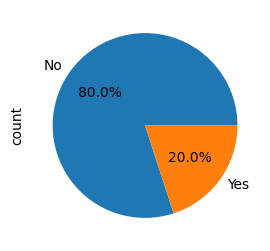

In [101]:
# Helper function for data distribution
def visualise_data_distribution(data):
    value_count = ""
    if isinstance(data, pd.DataFrame):
        value_count = data["death_yn"].value_counts()
    else:
        value_count = data.value_counts()
    value_count.plot(kind='pie',figsize=(3,3),autopct='%1.1f%%')
    plt.show()

# Visualize the proportion of target outcome
visualise_data_distribution(df)

In [104]:
# Create a prediction set of 100% "No" death_yn
y_simple_pred = pd.Series(['No'])
y_simple_pred = y_simple_pred.repeat(50000)
y_simple_pred = y_simple_pred.astype('category')

#evaluating simple prediction
evaluate(y,y_simple_pred)

Accuracy: 0.8
Confusion Matrix:
 [[40000     0]
 [10000     0]]
Precision: 1.0
Recall: 0.0
F1 Score: 0.0


(0.8,
 array([[40000,     0],
        [10000,     0]]),
 1.0,
 0.0,
 0.0)

### Findings:

The random forest model performs better than linear and logistic regression models when it comes to predicting the outcome of target feature(death_yn). This model outperformed the other two in cross-validation as well as on training and test sets.These findings highlight how good random forest is at distinguishing the positive and negative cases, and maintain consistent outcomes across different data splits.Please refer to the dataframe above to get exact idea of comparison metrics for each model on the test set.

The results are not surprising at all. First, while linear regression has a good performance in this problem overall, its implementation yields prediction results in continuous values instead of discrete values 1(Yes) and 0 (No). Using mathematical formulas to transform these continuous outcomes to discrete ones may have an impact on the prediction's accuracy. Also it is evident that it has worse metrics than the other two models which are designated for classification problems. Second, between two classification models, random forest performs better because the problem is quite complex, given that almost all the categorical features have more than two categories, and none of them have a clear linear relationship with the outcome.This makes random forest become more powerful than logistic regression, because random forest performs the prediction by creating a large number of decision trees and combining their prediction to arrive at the overall prediction. On the other hand, Logistic regression is a linear model that is used for simpler problems than the one we have on hand. However, the performance of linear regression and logistic regression was still commendable in predicting the outcome.

All three models performed better than majority model. Based on the data provided the accuracy of majority model is 80% which is considerably low when comapred to the rest. Additionally, the three models are good are forecasting the targeted feature, properly handling false positives and false negatives. The F1 score of majority model is 0.0 which is due to the unbalanced nature of the model which is shown by metrics like precision(1.0) and recall(0.0, the model cannot predict "Yes" as an outcome).

Accuracy represents the ratio of correct predictions, while precision and recall focus on the models' capacity to correctly anticipate positive cases. The F1 score, as the harmomic mean of precision and recall, strikes a balance between the two, proving particularly useful when addressing imbalanced datasets.

It is clear that the random forest model performs better than linear regression and logistic regression. Moreover, all three models show higher performance in all aspects(accuracy, precision, F1 and recall) when compared to simple majority class model, hence making them better choices for predicting the target feature.

## 5.2 Summarise your understanding of the problem and of your predictive modeling results so far.


### Summary of the problem and proposed methods to improve the best model:

The problem given involved predicting a binary(true or false, Yes or No) target feature based on a set of input features. We have explored three predictive models, namely Linear Regression, Logistic Regression, and Random Forest, to address this problem. After analysing the performance metrics (accuracy, precision, recall, and F1 score) of each model on the training and test sets, as well as after running cross-validation, it was deduced that the Random Forest model performed better the other two models and all three models outperformed simple majority class model in every aspect.

There are several ways we can attempt to improve the best model so far (the Random Forest model) by employing further data preparation or refining our modelling approach.

Some of the proposed ideas include:

- **Balancing the input model:** Due to the uneven distribution of the input model in each class, the model can be improved by using cluster-based oversampling, random undersampling or SMOTE oversampling.

- **Hyperparameter Tuning:** The model's performance can be improved by optimising its hyper parameters like number of trees, tree depth using methods like grid search and random search.

- **Feature Rescaling:** The performance of the model may be improved by rescaling the features using normalisation or standardisation techniques.


### Method 1: Random Undersampling

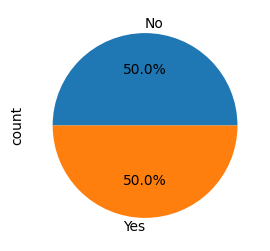

(14086, 129)

In [105]:
# Create a new train data set from the old train data set
X_train_copy = X_train.copy()

# Merge target feature to predictors in training dataset
X_train_copy['death_yn'] = y_train

y_yes = X_train_copy[X_train_copy['death_yn'] == "Yes"]
y_yes.shape[0]

y_no = X_train_copy[X_train_copy['death_yn'] == "No"]
y_no.shape[0]

y_no_undersample = y_no.sample(y_yes.shape[0])
y_no_undersample

undersample = pd.concat([y_no_undersample, y_yes], axis = 0)
visualise_data_distribution(undersample)
undersample.shape

In [106]:
# Create new dataset for training
X_undersamp_train=undersample.drop("death_yn", axis = 1)
y_undersamp_train=undersample["death_yn"]

# retrain the Random Forest model with the undersample dataset
rf_undersamp = RandomForestClassifier(random_state=30)
rf_undersamp.fit(X_undersamp_train, y_undersamp_train)

RandomForestClassifier(random_state=30)

In [107]:
y_train_rf_undersamp_pred = rf_undersamp.predict(X_undersamp_train)
print("UNDER SAMPLING METRICS(TRAIN SET)")
evaluate_undersamp_train = evaluate(y_undersamp_train, y_train_rf_undersamp_pred)

y_test_rf_undersamp_pred = rf_undersamp.predict(X_test)
print("UNDER SAMPLING METRICS(TEST SET)")
evaluate_undersamp_test = evaluate(y_test, y_test_rf_undersamp_pred)

UNDER SAMPLING METRICS(TRAIN SET)
Accuracy: 0.9913389180746841
Confusion Matrix:
 [[6956   87]
 [  35 7008]]
Precision: 0.9877378435517971
Recall: 0.995030526764163
F1 Score: 0.9913707738011034
UNDER SAMPLING METRICS(TEST SET)
Accuracy: 0.9366
Confusion Matrix:
 [[11214   829]
 [  122  2835]]
Precision: 0.7737445414847162
Recall: 0.9587419682110246
F1 Score: 0.8563661078386949


### Method 2: SMOTE Oversampling

In [111]:
#I had to create a custom smote because smote cannot perform subtraction on boolean
class CustomSMOTE(SMOTE):
    def _generate_samples(self, X, nn_data, nn_num, rows, cols, steps):
        # Perform logical_xor operation instead of boolean subtraction
        diffs = np.logical_xor(nn_data[nn_num[rows, cols]], X[rows])
        return (X[rows] + steps * diffs)

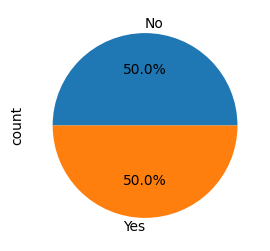

In [112]:
# smote = SMOTE(sampling_strategy='minority')
smote = CustomSMOTE(sampling_strategy='minority')
# Step 3: Apply SMOTE to the training data
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train, y_train)

# Step 4: Visualize the data distribution after applying SMOTE
visualise_data_distribution(y_train_SMOTE)

In [113]:
# retrain the Random Forest model with the undersample dataset
rf_smote = RandomForestClassifier(random_state=30)
rf_smote.fit(X_train_SMOTE, y_train_SMOTE)

RandomForestClassifier(random_state=30)

In [114]:
y_train_rf_smote_pred = rf_smote.predict(X_train_SMOTE)
print("SMOTE OVERSAMPLING METRICS(TRAIN SET)")
evaluate_smote_train = evaluate(y_train_SMOTE, y_train_rf_smote_pred)

y_test_rf_smote_pred = rf_smote.predict(X_test)
print("SMOTE OVERSAMPLING METRICS(TEST SET)")
evaluate_smote_test = evaluate(y_test, y_test_rf_smote_pred)

SMOTE OVERSAMPLING METRICS(TRAIN SET)
Accuracy: 0.9922917337339485
Confusion Matrix:
 [[27677   280]
 [  151 27806]]
Precision: 0.9900306202378409
Recall: 0.9945988482312123
F1 Score: 0.9923094766518565
SMOTE OVERSAMPLING METRICS(TEST SET)
Accuracy: 0.9525333333333333
Confusion Matrix:
 [[11628   415]
 [  297  2660]]
Precision: 0.865040650406504
Recall: 0.8995603652350355
F1 Score: 0.8819628647214853


### Method 3: Hyperparameter tuning using RandomizedSearchCV:

We want to improve the performance of RandomForest (RF) classifier by performing hyperparameter tuning using RandomizedSearchCV. An optimal combination of hyper parameters is found by applying the RandomizedSearchCV technique on the RF model and creating a dictionary of parameter distributions.

In [116]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4)
}

rf_random = RandomForestClassifier(random_state=30)
random_search = RandomizedSearchCV(estimator=rf_random, param_distributions=param_dist, n_iter=20, cv=5, scoring='f1_macro', random_state=30)
random_search.fit(X_train, y_train)
print("Optimal parameters found using RandomizedSearchCV:", random_search.best_params_)

Optimal parameters found using RandomizedSearchCV: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 279}


### Method 4: Feature scaling using StandardScaler:
The features are scaled, and the RF classifier is then trained on the scaled features.

In [117]:
from sklearn.preprocessing import StandardScaler

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_scaled = RandomForestClassifier(**random_search.best_params_, random_state=30)
rf_scaled.fit(X_train_scaled, y_train)
y_train_scaled_pred = rf_scaled.predict(X_train_scaled)
y_test_scaled_pred = rf_scaled.predict(X_test_scaled)

In [118]:
# Metrics for the scaled feature model
print("SCALED FEATURES METRICS(TRAINING SET)")
evaluate_sf_train = evaluate(y_train, y_train_scaled_pred)

print("SCALED FEATURES METRICS(TEST SET)")
evaluate_sf_test = evaluate(y_test, y_test_scaled_pred, "Yes")

SCALED FEATURES METRICS(TRAINING SET)
Accuracy: 0.9797714285714286
Confusion Matrix:
 [[27627   330]
 [  378  6665]]
Precision: 0.9528234453180844
Recall: 0.9463296890529603
F1 Score: 0.9495654651659782
SCALED FEATURES METRICS(TEST SET)
Accuracy: 0.956
Confusion Matrix:
 [[11689   354]
 [  306  2651]]
Precision: 0.8821963394342762
Recall: 0.8965167399391275
F1 Score: 0.88929889298893


### Summary for proposed models to improve performance

In [ ]:
summary_data.extend([
    ("Undersampling", "train", evaluate_undersamp_train[0], evaluate_undersamp_train[2], evaluate_undersamp_train[3], evaluate_undersamp_train[4]),
    ("Undersampling", "test", evaluate_undersamp_test[0], evaluate_undersamp_test[2], evaluate_undersamp_test[3], evaluate_undersamp_test[4]),
    ("SMOTE Oversampling", "train", evaluate_smote_train[0], evaluate_smote_train[2], evaluate_smote_train[3], evaluate_smote_train[4]),
    ("SMOTE Oversampling", "test", evaluate_smote_test[0], evaluate_smote_test[2], evaluate_smote_test[3], evaluate_sm_test[4]),
    ("Standard Scaler", "train", evaluate_sf_train[0], evaluate_sf_train[2], evaluate_sf_train[3], evaluate_sf_train[4]),
    ("Standard Scaler", "test", evaluate_sf_test[0], evaluate_sf_test[2], evaluate_sf_test[3], evaluate_sf_test[4])
])



In [121]:
summary = pd.DataFrame(summary_data, columns=['Model', 'Data set', 'Accuray', 'Precision', 'Recall', 'F1 Score'])
summary

,Model,Data set,Accuray,Precision,Recall,F1 Score
0,Linear Regression,Train,0.948029,0.905968,0.827630,0.865029
1,Linear Regression,Test,0.948467,0.895080,0.836659,0.864884
2,Linear Regression,Cross Validate,0.947780,0.901440,0.829507,0.863956
3,Logistic Regression,Train,0.955571,0.898258,0.878745,0.888394
4,Logistic Regression,Test,0.955400,0.888851,0.884342,0.886591
5,Logistic Regression,Cross Validate,0.954580,0.932341,0.924588,0.928390
6,Random Forest,Train,0.988371,0.969706,0.972597,0.971149
7,Random Forest,Test,0.954867,0.879494,0.893473,0.886428
8,Random Forest,Cross Validate,0.954640,0.928415,0.930175,0.929275
9,Undersampling,train,0.991339,0.987738,0.995031,0.991371


### Summary of the findings from improvement methods testing:

We implemented various techniques to enhance the Random Forest model, such as Undersampling, SMOTE Oversampling and Standard Scaler

Based on the provided results, the original Random Forest model performed reasonably well, with an accuracy of 0.954 on both the test set and the validation set. However, the goal was to improve its performance further using the suggested methods.

Undersampling demonstrates a considerable improvement in the training set with an accuracy of 0.991 and an F1 score of 0.991. However, the test set results showed a slightly lower accuracy (0.936) and F1 score (0.856) compared to the original Random Forest model. However, the recall value of this model on the Test is still the highest among all the models.

Among all the models, SMOTE oversampling had the best accuracy(0.992) and the best F1 score (0.992) on the training set. Likewise, the test set results (Accuracy-0.952, F1- 0.881) show that using SMOTE has really bested the initial random forest model. This means SMOTE with random forest may be a very feasible alternative.

In comparison to initial random forest model, applying Standard Scaler to the features yielded marginally better results on 0.956 accuracy and 0.889 F1 score. This leads to conclusion that feature scaling doesn't have a significant impact on the model.

In conclusion, among the proposed techniques to improve the Random Forest model, SMOTE Oversampling appears to be the most promising, with the highest accuracy and F1 score on both the training and test sets.